 
# Image Captioning with Conditioned LSTM Generators

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Follow the instructions in this notebook step-by-step. Much of the code is provided, but some sections are marked with **todo**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Implement two `Dataset`s to return training instances (input/output sequence pairs) for language modeling and image captioning.
* Train an LSTM language generator on the captions.
* Implement a greedy decoder function for the language generator. 
* Train an LSTM caption generator on both the images and their captions. 
* Implement 1) a greedy decoder function, 2) a nucleus decoder function and 3) a beam search decoder for the image caption generator.
* Implement BLEU and use it to evaluate our trained model.

Please submit a copy of this notebook with your assignment, including all outputs. Do not submit any of the data files. 

### Getting Started 

In [2]:
import os
import PIL
import types
import numpy as np
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

from google.colab import drive

import torch
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn import Module, Identity, Sequential, Embedding, Linear, LSTM, CrossEntropyLoss

import torchvision.models as models
from collections import Counter

if torch.cuda.is_available():
  print("Using GPU!")
  device = torch.device("cuda")
else:
  print("Using CPU... this is going to be slow...")
  device = torch.device("cpu")

/opt/conda/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


Using GPU!


In [3]:
# credit to https://gist.github.com/ax3l/59d92c6e1edefcef85ac2540eb056da3

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val
        # functions / callables
        if hasattr(val, '__call__'):
            yield name, val

noglobal = lambda fn: types.FunctionType(fn.__code__, dict(imports()))

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results


In [1]:
# This is where you put the name of your data folder.
# Please make sure it's correct because it'll be used in many places later.
my_data_dir="data"

## Part I: Image Encodings

The files `Flickr_8k.trainImages.txt` and `Flickr_8k.devImages.txt` contain lists of training and development images. 

In [6]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [7]:
train_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(my_data_dir, 'Flickr_8k.devImages.txt'))

Let's see how many images there are

In [ ]:
len(train_list), len(dev_list)

(6000, 1000)

Each entry is an image filename.

In [ ]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [8]:
IMG_DIR = "Flickr8k_Dataset"

We can use PIL to open the image and matplotlib to display it. 

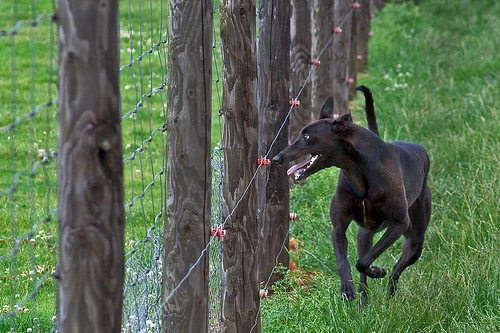

In [ ]:
image = PIL.Image.open(os.path.join(my_data_dir, IMG_DIR, dev_list[20]))
image

if you can't see the image, try

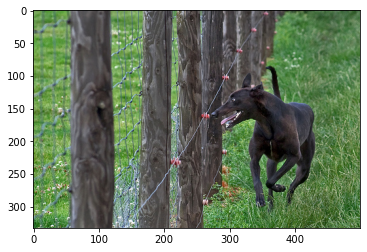

In [ ]:
plt.imshow(image)

We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolutional neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

We can use PIL to resize the image and then divide every value by 255. 

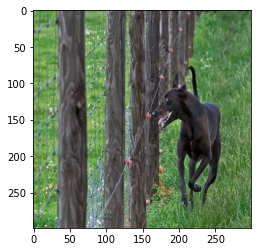

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

In [9]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(my_data_dir, IMG_DIR, image_name))
    return torch.tensor(np.transpose((np.asarray(image.resize((299,299))) / 255.0), axes=(2, 0, 1))).float()                 

In [ ]:
dump=get_image(dev_list[25])
dump.shape

torch.Size([3, 299, 299])

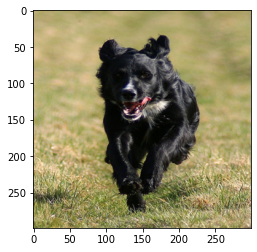

In [ ]:
plt.imshow(np.transpose(get_image(dev_list[25]).numpy(), axes=(1, 2, 0)))

Next, we load the pre-trained Inception model. 

In [ ]:
# This will download the weights for you
img_encoder = models.inception_v3(pretrained=True) 

In [ ]:
# This is quite a complex model
img_encoder

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

This is a prediction model, so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We'll use the following hack: we'll replace the final classification layer with the identity function.

In [ ]:
# We disable the final classification layer
img_encoder.fc = Identity()

# And we also disable dropout (by putting the model into eval mode)
img_encoder = img_encoder.to(device).eval()

Let's try the encoder. 

In [ ]:
new_image = get_image(dev_list[20])
with torch.no_grad():
  encoded_image = img_encoder(new_image.unsqueeze(dim=0).to(device))

In [ ]:
encoded_image

tensor([[0.2908, 0.5819, 0.0683,  ..., 0.7615, 0.9820, 0.4834]],
       device='cuda:0')

We will need to create encodings for all images and store them in one big matrix (one for each dataset: train and dev).
We can then save the matrices so that we never have to touch the bulky image data again. 


Following generator function, which should return up to 256 images at a time. 
`img_list` is a list of image file names (i.e. the train or dev set). The return value should be a tensor of shape (256, 3, 299, 299).

In [10]:
BATCH_SIZE = 256

path = os.path.join(my_data_dir, IMG_DIR)
def img_generator(img_list):
    num = 0
    while num<len(img_list):
      images = [torch.unsqueeze(get_image(image_name),0) for image_name in img_list[num:num+BATCH_SIZE]]
      images = torch.cat(images,dim=0)
      yield images
      num += BATCH_SIZE

Now we can encode all images.

In [ ]:
def encode_images(img_encoder, subset):
  encoded = []
  with torch.no_grad():
    for images in tqdm(img_generator(subset)):
      for image in img_encoder(images.to(device)).cpu():
        encoded.append(image)
  return torch.stack(encoded, dim=0)

enc_train = encode_images(img_encoder, train_list)

24it [02:03,  5.16s/it]


In [ ]:
enc_train[11]

tensor([0.4268, 1.0647, 0.3190,  ..., 0.9020, 0.1408, 0.6278])

In [ ]:
enc_dev = encode_images(img_encoder, dev_list)

4it [00:20,  5.16s/it]


It's a good idea to save the resulting matrices so we don't have to run the encoder again. 

And now that we're done with the image encoder, we can clear it from the GPU.

In [ ]:
torch.save(enc_train, os.path.join(my_data_dir, "outputs/encoded_images_train.pt"))
torch.save(enc_dev, os.path.join(my_data_dir, "outputs/encoded_images_dev.pt"))

# Now, let's delete the image encoder and get some GPU RAM back!
del img_encoder

## Part II Text (Caption) Data Preparation

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

Read the image descriptions from the file `filename` and returns a dictionary in the following format:
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so we can just split them at white spaces. Convert each token to lower case. Pad each caption with a START token on the left and an END token on the right. 

In [11]:
@noglobal
def read_image_descriptions(_filename):    
    image_descriptions = defaultdict(list)    
    with open(_filename) as f:
      descriptions = f.read().splitlines()
    for description in descriptions:
      img_details = description.split('#')
      img_description = '<START> '+ description[len(img_details[0])+2:].strip().lower() +' <END>'
      image_descriptions[description[:len(img_details[0])]].append(img_description.split(' '))
    return image_descriptions

In [12]:
descriptions = read_image_descriptions(os.path.join(my_data_dir, "Flickr8k.token.txt"))

In [13]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


### Creating Word Indices (a Vocabulary)

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

Create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.

In [16]:
train_vocab = set()
for img_name in train_list:
  for captions in descriptions[img_name]:
    #print(captions)
    for caption_token in captions:
      train_vocab.add(caption_token)

train_vocab = list(train_vocab)
train_vocab.sort()
train_vocab.insert(0,'<PAD>')

In [17]:
id_to_word, word_to_id = {}, {}
for index,word in enumerate(train_vocab):
  id_to_word[index] = word
  word_to_id[word] = index

In [19]:
# This should print an integer
word_to_id['dog'] 

1986

In [21]:
# This should print a token
id_to_word[1986] 

'dog'

Note that we do not need an UNK word token as we are generating from our vocabulary. The generated text will only contain tokens seen at training time.  

## Part III Basic Decoder Model

For now, we will just train a model for text generation (a language model) without conditioning the generator on the image input. 

We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [22]:
MAX_LEN = max(
    len(description) for image_id in train_list 
    for description in descriptions[image_id]
)

assert MAX_LEN == 40

We will use our model to predict one word at a time, given a partial sequence (i.e., next word prediction). For example, given the partial sequence ["START","a"], the model might predict "dog" as the most likely next word. We'll use an LSTM to encode the partial sequence.


To build our training set, we will convert each description into a set of input, output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train our model using the following input/output pairs 

| i | input (partial sequence)     | output (next word) |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `.`  |
| 3 |[`START`,`a`, `black`, `dog`, `.`] | `END`  |



Here is the model in `torch`. Note that we are using a bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [ ]:
class LanguageModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.lstm = LSTM(
        embedding_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    embedded = self.embeddings(seqs)
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            embedded, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

VOCAB_SIZE = len(word_to_id)
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
language_model = LanguageModel(device, VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE).to(device)

language_model

LanguageModel(
  (embeddings): Embedding(7707, 300)
  (lstm): LSTM(300, 512, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=7707, bias=True)
)

The model input is a tensor of size `(BATCH_SIZE, MAX_LEN)`. Each row is a vector of size up to `MAX_LEN` in which each entry is an integer representing a word (according to the `word_to_id` dictionary). Any sequence shorter than the longest in the batch should be padded with `0`. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a tensor of size `(BATCH_SIZE, VOCAB_SIZE)`. `VOCAB_SIZE` is the number of vocabulary words. 

### Creating a Dataset for the Training Data


Class `CaptionDataset` below that:

1 - takes a parameter `subset` (one of `train_list` or `dev_list`)

2 - implements `__getitem__(idx)` which returns an `(input, output)` pair. `input` is a partial input sequence encoded as a list of its indices in `word_to_id`, `output` contains the next word that should be predicted for the partial input sequence encoded as its index in `word_to_id`

3 - implements `__len__` which returns the total number of partial input sequences across the whole subset



In [23]:

class CaptionDataset(Dataset):

  @noglobal
  def __init__(self, _descriptions, _word_to_id, _subset):
    #
    self._descriptions = _descriptions
    self._word_to_id = _word_to_id
    self._subset = _subset
    self._seq = []
    for img_name in self._subset:
      for img_captions in self._descriptions[img_name]:
        temp = [(self._word_to_id['<START>'],)]
        for token in img_captions[1:]:
          self._seq.append((temp[-1],self._word_to_id[token]))
          temp.append((*temp[-1],self._word_to_id[token]))
  

  @noglobal 
  def __len__(self):
    #
    return len(self._seq)

  @noglobal
  def __getitem__(self, idx):
    #
    return self._seq[idx]

c = CaptionDataset(descriptions, word_to_id, train_list)
assert len(CaptionDataset(descriptions, word_to_id, train_list)) == 383454

### Training the Model

In [ ]:
def collate(batch):
  partial_sequences, continuations = [], []
  for (partial_sequence, continuation) in batch:
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  return (
      pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
      torch.tensor(continuations)
  )

batch_size = 4096
train_loader = DataLoader(
    CaptionDataset(descriptions, word_to_id, train_list), 
    collate_fn=collate, batch_size=batch_size, shuffle=True
)

optimizer = Adam(language_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def handle_batch(model, criterion, batch):
  partial_captions, continuations = batch
  predictions = model(partial_captions.to(model.device))
  return criterion(predictions, continuations.to(model.device))

for epoch in range(10):
  t_tot_loss = 0.0
  language_model.train()
  for t_batch in tqdm(train_loader):
    optimizer.zero_grad()
    t_loss = handle_batch(language_model, criterion, t_batch)
    t_loss.backward()
    optimizer.step()

    t_tot_loss += t_loss.cpu().item()
  
  print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))

100%|███████████████████████████████████████████| 94/94 [00:49<00:00,  1.89it/s]


epoch=0 t_loss=411.4661


100%|███████████████████████████████████████████| 94/94 [00:49<00:00,  1.88it/s]


epoch=1 t_loss=312.5374


100%|███████████████████████████████████████████| 94/94 [00:49<00:00,  1.88it/s]


epoch=2 t_loss=284.3868


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.88it/s]


epoch=3 t_loss=265.8673


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.87it/s]


epoch=4 t_loss=250.8888


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.88it/s]


epoch=5 t_loss=237.3809


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.88it/s]


epoch=6 t_loss=224.6742


100%|███████████████████████████████████████████| 94/94 [00:49<00:00,  1.88it/s]


epoch=7 t_loss=212.9061


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.88it/s]


epoch=8 t_loss=201.6023


100%|███████████████████████████████████████████| 94/94 [00:50<00:00,  1.88it/s]

epoch=9 t_loss=190.7182


### Greedy Decoder

The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [ ]:
torch.save(language_model, 'lang_model.pt')
language_model = torch.load('lang_model.pt')

In [ ]:
@noglobal
def greedy_decoder(_word_to_id, _id_to_word, _language_model, _max_len, _device):
    # ...
    id_seq = [_word_to_id['<START>']]
    l = 1
    softmax = torch.nn.Softmax(dim=1)
    while ( l< _max_len and not id_seq[-1] == _word_to_id['<END>'] ) :
      
      seq_input = torch.LongTensor([id_seq]).to(_device)
      next_word_id = torch.argmax(softmax(_language_model(seq_input)))
      id_seq.append(next_word_id.item())
      l += 1
    
    word_seq = [_id_to_word[i] for i in id_seq]
    return word_seq

In [ ]:
print(greedy_decoder(word_to_id, id_to_word, language_model, MAX_LEN, device))

['<START>', 'a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'jeans', 'stands', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'group', 'of', 'people', '.', '<END>']


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

## Part III - Conditioning on the Image

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the torch model looks like: 

In [24]:
class ImageCaptioningModel(Module):
  def __init__(self, device, vocab_size, embedding_dim, image_dim, hidden_dim):
    super().__init__()
    self.device = device
    self.embeddings = Embedding(vocab_size, embedding_dim)
    self.img_fc = Linear(image_dim, hidden_dim)
    self.lstm = LSTM(
        embedding_dim + hidden_dim, hidden_dim, num_layers=1, 
        bidirectional=True, batch_first=True
    )
    self.fc = Linear(2 * hidden_dim, vocab_size)
  
  def forward(self, images, seqs):
    seq_lens = torch.count_nonzero(seqs, dim=1).cpu()
    rnn_input = torch.cat(
        (
            self.embeddings(seqs),
            torch.relu(self.img_fc(images)).unsqueeze(
                dim=1).repeat(1, seqs.shape[1], 1)
        ), dim=2
    )
    _, (h_n, _) = self.lstm(
        pack_padded_sequence(
            rnn_input, lengths=seq_lens, 
            batch_first=True, enforce_sorted=False
        )
    )
    hidden_states = torch.cat((h_n[0], h_n[1]), dim=1)
    return self.fc(hidden_states)

In [25]:
VOCAB_SIZE=len(word_to_id)
EMBEDDING_DIM=300
IMAGE_DIM=2048
HIDDEN_DIM=256
caption_model = ImageCaptioningModel(
    device, VOCAB_SIZE, EMBEDDING_DIM, IMAGE_DIM, HIDDEN_DIM).to(device)
caption_model

ImageCaptioningModel(
  (embeddings): Embedding(7708, 300)
  (img_fc): Linear(in_features=2048, out_features=256, bias=True)
  (lstm): LSTM(556, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=7708, bias=True)
)

The model now takes two inputs: 
    
   1. a `(BATCH_SIZE, 2048)` tensor of image encodings. 
   2. a `(BATCH_SIZE, MAX_LEN)` tensor of partial input sequences. 
    
And one output as before: a `(BATCH_SIZE, VOCAB_SIZE)` tensor of predicted word distributions.   

`ImageCaptioningDataset`, that includes the image with each input/output pair. It needs to return a 3-tuple of `image_input, text_input, next_word` where each element is an array.  The `collate` function will handle converting them to tensors.


In [26]:
enc_train = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_train.pt"))
enc_dev = torch.load(os.path.join(my_data_dir, "outputs/encoded_images_dev.pt"))

In [27]:
class ImageCaptioningDataset(Dataset):
  @noglobal
  def __init__(self, _descriptions, _word_to_id, _subset, _image_encodings):
    
    self._seq = []
    for index, img_name in enumerate(_subset):
      for img_captions in _descriptions[img_name]:
        temp = [(_word_to_id['<START>'],)]
        for token in img_captions[1:]:
          _word_id = _word_to_id[token] if token in _word_to_id else 0
          self._seq.append((_image_encodings[index].cpu().numpy(),temp[-1],_word_id))
          temp.append((*temp[-1],_word_id))

  @noglobal 
  def __len__(self):
    return len(self._seq)

  @noglobal  
  def __getitem__(self, idx):
    return self._seq[idx]

assert len(ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train)) == 383454

In [28]:
def collate(batch):
  images, partial_sequences, continuations = [], [], []
  for (image, partial_sequence, continuation) in batch:
    images.append(image)
    partial_sequences.append(torch.tensor(partial_sequence))
    continuations.append(continuation)
  try:
    return (
        torch.tensor(np.array(images)), 
        pad_sequence(partial_sequences, batch_first=True, padding_value=0), 
        torch.tensor(continuations)
    )
  except Exception as e:
    print(e)

batch_size = 4096
train_loader = DataLoader(
    ImageCaptioningDataset(descriptions, word_to_id, train_list, enc_train), 
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

dev_loader = DataLoader(
    ImageCaptioningDataset(descriptions, word_to_id, dev_list, enc_dev), 
    collate_fn=collate, 
    batch_size=batch_size, 
    shuffle=True
)

optimizer = Adam(caption_model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def handle_batch(model, criterion, batch):
  images, partial_captions, continuations = batch
  predictions = model(images.to(model.device), partial_captions.to(model.device))
  return predictions, criterion(predictions, continuations.to(model.device))

prev_loss = float('inf')
for epoch in range(20):
  t_tot_loss = 0.0
  caption_model.train()
  for t_batch in tqdm(train_loader):
    optimizer.zero_grad()
    _, t_loss = handle_batch(caption_model, criterion, t_batch)
    t_loss.backward()
    optimizer.step() 

    t_tot_loss += t_loss.cpu().item()
  
  print("epoch=%s t_loss=%0.4f" % (epoch, t_tot_loss))

100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.51it/s]


epoch=0 t_loss=452.7567


100%|███████████████████████████████████████████| 94/94 [00:37<00:00,  2.54it/s]


epoch=1 t_loss=355.2591


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.63it/s]


epoch=2 t_loss=319.8482


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.61it/s]


epoch=3 t_loss=295.4516


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.62it/s]


epoch=4 t_loss=276.3778


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.61it/s]


epoch=5 t_loss=261.3433


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.62it/s]


epoch=6 t_loss=248.2350


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.64it/s]


epoch=7 t_loss=236.7834


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.61it/s]


epoch=8 t_loss=226.2440


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.62it/s]


epoch=9 t_loss=216.3940


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.61it/s]


epoch=10 t_loss=207.4701


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.63it/s]


epoch=11 t_loss=198.6432


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.64it/s]


epoch=12 t_loss=190.5432


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.58it/s]


epoch=13 t_loss=182.8273


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.63it/s]


epoch=14 t_loss=175.5916


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.59it/s]


epoch=15 t_loss=168.5265


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.62it/s]


epoch=16 t_loss=162.0200


100%|███████████████████████████████████████████| 94/94 [00:36<00:00,  2.60it/s]


epoch=17 t_loss=155.7137


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.63it/s]


epoch=18 t_loss=149.4366


100%|███████████████████████████████████████████| 94/94 [00:35<00:00,  2.63it/s]

epoch=19 t_loss=143.4670


In [29]:
torch.save(caption_model.state_dict(), os.path.join(my_data_dir, "outputs/model.pt"))

to load the model: 

In [30]:
caption_model.load_state_dict(torch.load(os.path.join(my_data_dir, "outputs/model.pt")))

caption_model = caption_model.to(device).eval()

Updated greedy decoder, adapting what we wrote for the text-only generator so that it takes an encoded image (a tensor of length `2048`) as input, and returns a text sequence.

In [31]:
@noglobal
def image_greedy_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, _enc_image): 
    # ...
    id_seq = [_word_to_id['<START>']]
    softmax = torch.nn.Softmax(dim=1)
    l = 1
    img_input = _enc_image.unsqueeze(0).to(_device)
    while ( l< _max_len and not id_seq[-1] == _word_to_id['<END>'] ) :
      seq_input = torch.LongTensor([id_seq]).to(_device)
      next_word_id = torch.argmax(softmax(_caption_model(img_input,seq_input)))
      id_seq.append(next_word_id.item())
      l += 1
    
    word_seq = [_id_to_word[i] for i in id_seq]
    
    return word_seq

As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

['<START>', 'two', 'dogs', 'are', 'running', 'together', 'on', 'the', 'beach', '.', '<END>']


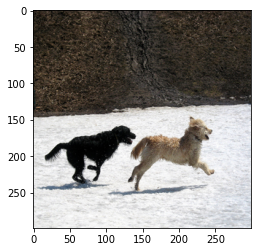

In [32]:
plt.imshow(np.transpose(get_image(train_list[0]).numpy(), axes=(1, 2, 0)))
print(image_greedy_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, enc_train[0]))

We should also be able to apply the model to dev images and get reasonable captions:

['<START>', 'a', 'football', 'player', 'runs', 'with', 'the', 'ball', '.', '<END>']


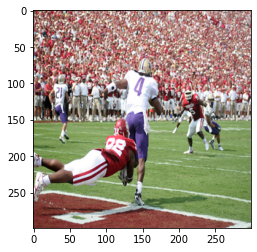

In [33]:
plt.imshow(np.transpose(get_image(dev_list[500]).numpy(), axes=(1, 2, 0)))
print(image_greedy_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, enc_dev[500]))

## Part IV - Beam Search and Nucleus Decoders

### Beam Search Decoder

Instead of always selecting the most probable word, use a *beam*, which contains the `n` highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities).

Then, for each sequence, compute the `n` most likely successor words. Append the word to produce `n` new sequences and compute their score. This way, we create a new list of `n*n` candidates. 

Prune this list to the best `n` as before and continue until `MAX_LEN` words have been generated. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current `n`. 

In [34]:
@noglobal
def image_beam_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, n, _enc_image):
  #...

  def get_next_partial_seq(_caption_model, _device, n, img_input, partial_seq, k_hyp):
  
    softmax = torch.nn.Softmax(dim=1)

    seq_input = torch.LongTensor([partial_seq[0]]).to(_device)
    preds_score, preds_indices = torch.topk(softmax(_caption_model(img_input,seq_input)),n)
    
    preds_score = preds_score.detach().cpu().numpy()[0]
    preds_indices = preds_indices.detach().cpu().numpy()[0]
    
    for pred_score,pred_index in zip(preds_score, preds_indices):
      k_hyp.append([partial_seq[0]+[pred_index],
                    (partial_seq[1]*len(partial_seq[0])+np.log(pred_score))\
                    /(len(partial_seq[0])+1)])
                    

    del seq_input
  
  id_seq = [[_word_to_id['<START>']],1]
  k_hyp = []
  img_input = _enc_image.unsqueeze(0).to(_device)
  
  get_next_partial_seq(_caption_model, _device, n, img_input, id_seq, k_hyp)

  l = 2
  
  no_change = 0
  while ( l< _max_len and no_change<n) :
    partial_hyp = []
    preds = []
    no_change = 0
    for i in range(n):
      
      if k_hyp[i][0][-1] == _word_to_id['<END>']:
        partial_hyp.append(k_hyp[i])
        no_change += 1
        continue
      
      get_next_partial_seq(_caption_model, _device, n, img_input, k_hyp[i], partial_hyp)

    partial_hyp.sort(key=lambda x:x[1], reverse=True)
    k_hyp = partial_hyp[:n]

    l += 1

  word_seq = [_id_to_word[i] for i in k_hyp[0][0]]
  return word_seq

['<START>', 'a', 'baseball', 'player', 'swings', 'a', 'bat', 'at', 'a', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'swings', 'the', 'bat', 'at', 'a', 'pitch', '.', '<END>']
['<START>', 'the', 'baseball', 'player', 'is', 'throwing', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'gets', 'ready', 'to', 'catch', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'gets', 'ready', 'to', 'catch', 'the', 'ball', '.', '<END>']
['<START>', 'a', 'baseball', 'player', 'gets', 'ready', 'to', 'catch', 'the', 'ball', '.', '<END>']


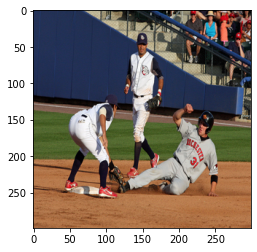

In [43]:
img_num = 100
plt.imshow(np.transpose(get_image(dev_list[img_num]).numpy(), axes=(1, 2, 0)))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 1, enc_dev[img_num]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 3, enc_dev[img_num]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 5, enc_dev[img_num]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 10, enc_dev[img_num]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 15, enc_dev[img_num]))
print(image_beam_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 20, enc_dev[img_num]))


### Nucleus Decoder

Rather than selecting the top `n` tokens at each decoding step, we could sample the next word from the distribution (i.e. the softmax activated output) returned by the model. This allows us to incorporate some randomness into the decoding process.  Below, we'll implement a specific sampling-based decoding strategy: nucleus sampling.  

In nucleus sampling \[[Holtzman et al., 2019](https://arxiv.org/abs/1904.09751)\], at each decoding step, we only consider the smallest subset of the vocabulary tokens whose cumulative probability mass reaches a predefined threshold `p` (the "nucleus" of the distribution).  The probability mass of truncated tokens is then redistributed to the selected tokens.  We sample the next word from this re-normalized truncated distribution.  


In [36]:
@noglobal
def image_nucleus_decoder(_word_to_id, _id_to_word, _caption_model, _max_len, _device, p, _enc_image):
  #...
  id_seq = [_word_to_id['<START>']]
    
  l = 1
  img_input = _enc_image.unsqueeze(0).to(_device)
  softmax = torch.nn.Softmax(dim=1)

  while ( l< _max_len and not id_seq[-1] == _word_to_id['<END>'] ) :

    seq_input = torch.LongTensor([id_seq]).to(_device)
    prob_dist = softmax(_caption_model(img_input,seq_input))
    sorted_prob_dist,prob_indices = torch.sort(prob_dist, descending=True)
    sorted_prob_dist = sorted_prob_dist[0]
    prob_indices = prob_indices[0]

    p_sum = 0
    p_ind = 0
    for index, value in enumerate(sorted_prob_dist):
      p_sum += value.cpu().item()
      if p_sum > p:
        p_ind = index+1
        break

    prob_dist = torch.div(sorted_prob_dist[:p_ind],p_sum)
    next_word_id = torch.distributions.categorical.Categorical(prob_dist).sample().item()
    id_seq.append(prob_indices[next_word_id].item())
    l += 1
 
  word_seq = [_id_to_word[i] for i in id_seq]
  
  return word_seq

Now, let's see what kind of output we get:

['<START>', 'a', 'football', 'player', 'takes', 'their', 'arms', 'around', 'for', 'the', 'ball', '.', '<END>']
['<START>', 'men', 'play', 'in', 'the', 'field', 'of', 'the', 'soccer', 'match', '.', '<END>']
['<START>', 'a', 'group', 'of', 'soccer', 'players', 'in', 'white', 'jumping', 'from', 'green', '.', '<END>']
['<START>', 'a', 'football', 'player', 'runs', 'past', 'a', 'sporting', 'football', 'game', '.', '<END>']
['<START>', 'a', 'man', 'punting', 'a', 'football', 'game', 'with', 'a', 'teammate', 'in', 'a', 'crowd', '.', '<END>']


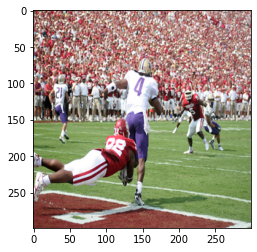

In [37]:
plt.imshow(np.transpose(get_image(dev_list[500]).numpy(), axes=(1, 2, 0)))
for i in range(5): 
    print(image_nucleus_decoder(word_to_id, id_to_word, caption_model, MAX_LEN, device, 0.95, enc_dev[500]))

## Part V - BLEU and Evaluation

Finally, let's evaluate our trained model on our development set.  A standard evaluation metric in language generation tasks in BLEU.

### Calculate BLEU

Candidate should be a list of words (the generated caption).  References should be a list of lists of words (the gold label captions).  Weights should be `n`-gram specific weights

In [38]:
@noglobal
def bleu(_candidate, _references, _weights):
  #
  def _n_gram_generator(_sentence, _n):
    _n_grams = []
    for i in range(0,len(_sentence)-_n+1):
      _n_grams.append(','.join(_sentence[i:i+_n]))
    return _n_grams

  def _get_clipped_precision(_candidate, _reference):
    
    _clipped_precision = 0
    _l = sum(_candidate.values())
    for _token in _candidate.keys():
      if _token in _reference:
        _clipped_precision +=  min(_candidate[_token], _reference[_token])
    
    return _clipped_precision/_l

  def _get_brevity_penalty(_candidate, _references):

    _cand_len = len(_candidate)
    _min_diff = float('inf')
    _closest_ref_len = 0
    _max_len = 0

    for _r in _references:
      _ref_len = len(_r)
      _diff = abs(_cand_len-_ref_len)
      if _diff < _min_diff:
        _min_diff = _diff
        _closest_ref_len = _ref_len
    
    if _cand_len > _closest_ref_len:
      return 1

    return np.exp(1-(_closest_ref_len/_cand_len))

  _cand_n_grams = []
  _ref_n_grams = []

  _brevity_penalty = _get_brevity_penalty(_candidate, _references)

  for _n in [1,2,3,4]:
    _cand_n_grams.append(Counter(_n_gram_generator(_candidate,_n)))

  _l = len(_candidate)
  
  for _n in [1,2,3,4]:
    _ref_counter = Counter()
    for _ref_sent in _references:
      _ref_counter = _ref_counter | Counter(_n_gram_generator(_ref_sent,_n))
    _ref_n_grams.append(_ref_counter)
  
  _non_zeros = 0
  _clipped_precisions = []
  _precision = 0
  for n in [1,2,3,4]:
    _clipped_precision = _get_clipped_precision(
                                  _cand_n_grams[n-1],
                                  _ref_n_grams[n-1]
                              )
    if _clipped_precision:
      _clipped_precisions.append(np.log(_clipped_precision))

  for _p in _clipped_precisions:
    _precision += 1/len(_clipped_precisions)*_p
  
  return _brevity_penalty*np.exp(_precision)


Now let's evaluate our various decoders.

In [40]:
def evaluate(decoder):
  bleu_scores = []
  caption_model.eval()
  for d_image, d_enc in zip(dev_list,enc_dev):
    bleu_scores.append(bleu(
        decoder(d_enc),
        descriptions[d_image],
        [1/4, 1/4, 1/4, 1/4]
    ))
  return np.mean(bleu_scores)

for (name, decoder) in [
  ('greedy', partial(image_greedy_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device)),
  ('beam-3', partial(image_beam_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 3)),
  ('beam-5', partial(image_beam_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 5)),
  ('nucleus-0.95', partial(image_nucleus_decoder, word_to_id, id_to_word, caption_model, MAX_LEN, device, 0.95))
]:
  print(name, evaluate(decoder))

greedy 0.32282535139401913
beam-3 0.33123589962043415
beam-5 0.33481138810971517
nucleus-0.95 0.27268030390059667
